# Mini Project 2

By the deadline, please submit the provided Jupyter notebook with all/some required tasks completed and clearly solved. Make sure your code is neat, well-commented, and that all outputs are visible (run all cells before saving). Notebooks with missing tasks or unexecuted cells may receive fewer points. After you submit, you won’t be able to make changes, so double-check your work and be sure to start from the provided template

## Submission rules
As already discussed in class, we will stick to the following rules.
- Use the templates and name your files `NAME_SURNAME.ipynb` (If you have more than one name, just concatenate them). We will compare what you present with that file. 
- Code either not written in Python or not using PyTorch receives a grade of 0. Of course, you can use auxiliary packages when needed (`matplotlib`, `numpy`, ...), but for the learning part, you must use PyTorch.
-  If plagiarism is suspected, TAs and I will thoroughly investigate the situation, and we will summon the student for a face-to-face clarification regarding certain answers they provided. In case of plagiarism, a score reduction will be applied to all the people involved, depending on their level of involvement.
-  If extensive usage of AI tools is detected, we will summon the student for a face-to-face clarification regarding certain answers they provided. If the answers are not adequately supported with in-person answers, we will proceed to apply a penalty to the evaluation, ranging from 10% to 100%.

## Image classification uning a CNN

The CIFAR-10 dataset is a widely used collection of images in the field of computer vision. It consists of 60000 (50000 for the training and 10000 for the test) 32x32 color images across 10 different classes, with each class containing 6,000 images. These classes include common objects such as airplanes, automobiles, cats, and dogs. CIFAR-10 serves as a benchmark for image classification tasks and has been instrumental in developing and evaluating machine learning algorithms for image recognition. 
The task of this assignment is to classify the images

In [53]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import numpy as np

### Task 0 (0 pts)
Understand what's going on in the two cells below. Do the following experiments: 
1. Run the first and the second cell in a row.
2. Run the first cell and two times in a row the second one.

What do you observe? We don't need any answer, but please just keep this phenomenon in mind. 

In [54]:
torch.manual_seed(0)

In [55]:
torch.randint(1, 10 , (1,1))

tensor([[9]])

Now, we'll set a seed that will remain the same for all the code below

### Task 1 (2.5 pts)
Load the [data (You can do it directly in PyTorch)](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) and take some time to inspect the dataset. Report here at least one image per class and a histogram of the distribution of the images of the training and test set. 

In [56]:
batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


<Figure size 640x480 with 0 Axes>

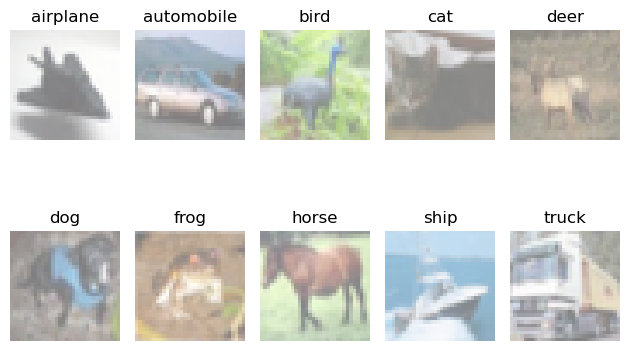

In [57]:
print(trainset)
#print(trainset.__getitem__(1)[0].shape)

plt.figure()
fig, axes = plt.subplots(2, 5)
axes = axes.flatten()

displayed_classes = set()

for img, label in trainset:
    if label not in displayed_classes:
        img_display = img.permute(1, 2, 0).numpy()
        img_display = (img_display / 2) + 0.5
        img_display = img_display.clip(0, 1)
        
        axes[label].imshow(img_display)
        axes[label].set_title(classes[label])
        axes[label].axis('off')
        
        displayed_classes.add(label)
    
    if len(displayed_classes) == 10:
        break

plt.tight_layout()
plt.show()

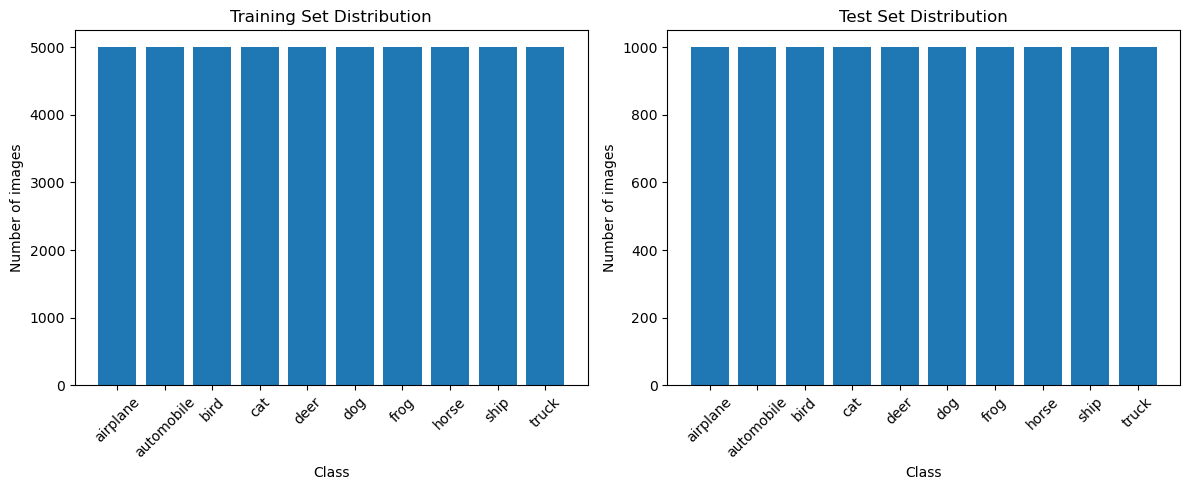

In [58]:
num_classes_train = {cls: 0 for cls in classes}
num_classes_test = {cls: 0 for cls in classes}
'''
for img, label in trainset:
    num_classes_train[classes[label]] += 1

for img, label in testset:
    num_classes_test[classes[label]] += 1
'''
train_counts = torch.bincount(torch.tensor(trainset.targets))
test_counts = torch.bincount(torch.tensor(testset.targets))

num_classes_train = {classes[i]: train_counts[i].item() for i in range(len(classes))}
num_classes_test = {classes[i]: test_counts[i].item() for i in range(len(classes))}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.bar(num_classes_train.keys(), num_classes_train.values())
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of images')
ax1.set_title('Training Set Distribution')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(num_classes_test.keys(), num_classes_test.values())
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of images')
ax2.set_title('Test Set Distribution')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Task 2 (2.5 pts)
Are the entries in the correct type for the DL framework in PyTorch? How can you arrive at a suitable format for your training pipeline? Be sure to have understood
- The type of each element of the dataset 
- How we can convert it to a suitable type.
- The dimension of the image as a `torch.Tensor` object
- The meaning of each dimension of the images 

In [59]:
# numpy.ndarray of (32, 32, 3) but we need Tensor of (3, 32, 32)
# Data already in the right format thanks to the transforms.ToTensor() 

element = next(iter(trainloader)) 
print(element[0].shape) # images: shape (batch_size, 3, 32, 32)
print(element[1].shape) # labels: shape (batch_size) 
    


torch.Size([32, 3, 32, 32])
torch.Size([32])


### Task 3 (10 pts)
When you arrive at this question you should have each entry as a `torch.Tensor` of shape (3,32, 32) and clear the meaning of each dimension. A good practice in DL is to work with features having mean 0 and standard deviation equal to 1. Convert the dataset of the images in this format. To do so, you can do it from scratch (not recommended) or use the function [`torchvision.transforms.Normalize`](https://pytorch.org/vision/0.8/transforms.html\#torchvision.transforms.Normalize). If you go for this second option, don't forget that we have already transformed our dataset in the previous point, hence, it could be of help using the function [`transforms.Compose`](https://pytorch.org/vision/0.8/transforms.html\#torchvision.transforms.Compose). You can see an example in the tutorial linked above.

**Note** that the usage of the function is tricky: try to really understand what's going on

In [ ]:
normalize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1,1,1])
])

trainset.transform = normalize_transform
testset.transform = normalize_transform

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


### Task 4 (1 pts)
As you might have observed, we only have a train and test set. We need a validation set for hyperparameter tuning. Create a validation set by splitting the test set. 

In [61]:
test_size = len(testset)
print(f"Old test set size: {test_size}\n")
val_size = test_size / 2
test_size = test_size - val_size

valset, testset = torch.utils.data.random_split(testset, [int(val_size), int(test_size)])

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print(f"Training set size: {len(trainset)}")
print(f"Validation set size: {len(valset)}")
print(f"Test set size: {len(testset)}")

Old test set size: 10000

Training set size: 50000
Validation set size: 5000
Test set size: 5000


### Task 5 (20 pts)
Starting from the code provided during Lecture 6, define a ConvNet. You can **only** use:

- Convolutional layers  
- Max/Avg Pooling layers  
- Activation Functions  
- Fully connected layers  

Note that the choice `Conv - Pool - Conv` is not mandatory. Have you tried `Conv - Conv - Activ - Pool - Conv - Conv - Activ - Pool - FC`?  
For each convolutional layer you can choose padding and stride. Be prepared on comment on the choices of the dimensions of the layers.

In [62]:
from math import floor

def out_dimensions(conv_layer, h_in, w_in):
    '''
    This function computes the output dimension of each convolutional layers in the most general way. 
    See here https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
    '''
    h_out = floor((h_in + 2 * conv_layer.padding[0] - conv_layer.dilation[0] * (conv_layer.kernel_size[0] - 1) - 1) /
                  conv_layer.stride[0] + 1)
    w_out = floor((w_in + 2 * conv_layer.padding[1] - conv_layer.dilation[1] * (conv_layer.kernel_size[1] - 1) - 1) /
                  conv_layer.stride[1] + 1)
    return h_out, w_out

In [63]:
kernel_size = 3

class CNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=kernel_size, padding=1)

        self.pool1 = nn.MaxPool2d(2, stride=2) # out: (32,16,16)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, padding=1) # out: (64,16,16)

        self.fc1 = nn.Linear(64 * 16 * 16,128)
        self.fc2 = nn.Linear(128,10)

        self.finalDim = (64, 16, 16)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        
        n_channels, h, w = self.finalDim
        x = x.view(-1, n_channels * h * w)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Task 6 (35 pts)
Implement the training pipeline. Make sure to code the following:

- Print and record the current training loss and accuracy every *n* steps (choose *n*)  
- Print and record the current validation loss and accuracy every *n* steps (choose *n*)  

The validation loss will help you in hyperparameter tuning. Train your model.  
With my choice of hyperparameters, the best test accuracy is above **65%**, hence, a necessary condition to get full marks is to achieve an accuracy on the test set greater or equal to **65%**.

You may want to follow some of these hints (**They are, of course, dependent on the architecture, optimizer, ...**):

- 5 epochs should be enough  
- Batch size = 32 could be a good starting point  
- A learning rate around 0.03 should be a good tradeoff between speed and stability  
- SGD should be a good optimizer  

Be prepared to answer the following questions:
- Why that learning rate? Why not higher/smaller?  
- Number of epochs: Why that number?  
- Some comments on your architecture: why that deep? why not deeper? why not smaller?  

In [64]:
model = CNN()
learning_rate = 0.01
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda')
model = model.to(DEVICE)

print("Working on", DEVICE)

Working on cuda


In [65]:
n_epochs = 5
train_loss_list = []
validation_loss_list = []

def trainBaseModel():
    for epoch in range(n_epochs):
        loss_train = 0
        n_samples = 0
        n_correct = 0

        for data, target in trainloader:
            model.train()

            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()

            output = model(data)

            loss = loss_fn(output, target)
            loss_train += loss.item()

            _, predicted = torch.max(output.data, 1)
            n_samples += target.size(0)
            n_correct += (predicted == target).sum().item()

            loss.backward()
            optimizer.step()
        loss_train = loss_train / len(trainloader) # Consider this alternative method of tracking training loss. 
        train_loss_list.append(loss_train)
        train_acc = 100.0 * n_correct / n_samples

        val_n_samples = 0
        val_n_correct = 0
        with torch.no_grad():
            model.eval()
            for data, target in valloader: # Just one batch
                data, target = data.to(DEVICE), target.to(DEVICE)
                # Make a prediction
                output = model(data)
                # Compute the loss function
                _, predicted = torch.max(output.data, 1)
                val_n_samples += target.size(0)
                val_n_correct += (predicted == target).sum().item()
        valid_acc = 100.0 * val_n_correct / val_n_samples 

        validation_loss = loss_fn(output, target).item()
        print(f"Epoch {epoch + 1}: Train loss: {loss_train:.6f}, with training accuracy of {train_acc:.2f}% \n\t Validation loss {validation_loss:.6f}, with validation accuracy of {valid_acc:.2f}%")
        validation_loss_list.append(validation_loss)

trainBaseModel()

Epoch 1: Train loss: 1.589614, with training accuracy of 42.17% 
	 Validation loss 1.101819, with validation accuracy of 52.66%
Epoch 2: Train loss: 1.159749, with training accuracy of 58.77% 
	 Validation loss 1.197262, with validation accuracy of 59.20%
Epoch 3: Train loss: 0.950547, with training accuracy of 66.37% 
	 Validation loss 1.561335, with validation accuracy of 64.52%
Epoch 4: Train loss: 0.764421, with training accuracy of 72.88% 
	 Validation loss 1.457464, with validation accuracy of 67.14%
Epoch 5: Train loss: 0.590938, with training accuracy of 79.26% 
	 Validation loss 1.685407, with validation accuracy of 67.62%


In [66]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 67.06 %


### Task 7 (4 pts)
Plot the evolution of the training and validation losses on the same graph. On the x-axis, you should preferably use the number of steps. Do you observe signs of overfitting or underfitting? Note that an improperly trained model will also result in a point deduction for the previous exercise.

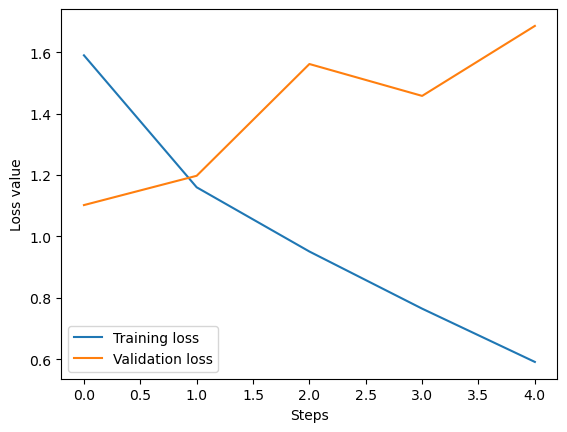

In [67]:
plt.plot(range(n_epochs), train_loss_list)
plt.plot(range(n_epochs), validation_loss_list)
plt.legend(["Training loss", "Validation loss"])
plt.xlabel("Steps")
plt.ylabel("Loss value")
plt.show()


### Task 8 (20 pts)
You may have noticed that it is quite likely to get overfitting in many cases, preventing it from going beyond 65% accuracy.  

Change the architecture as you like and try to increase the accuracy as much as possible. The base architecture must remain a ConvNet.  
Try any idea that comes to your mind but **justify it**.

Some hints:

- Add Dropout (Any other hyperparameter to tune?)  
- Change activation functions ([GeLU](https://arxiv.org/pdf/1606.08415v3.pdf) is known to work well with images)  
- Make your CNN deeper  
- Add some regularization techniques  
- Change the optimizer  
- Data augmentation  
- Batch normalization  
- …  

#### Points distribution:

- Any successful try (test accuracy increase): 6 points  
- Accuracy on test set ≥ 70% : 7 points  
- Accuracy on test set ≥ 72% : 8 points  
- Accuracy on test set ≥ 73% : 9 points  
- …  
- Accuracy on test set ≥ 78% : 15 points  

To get the remaining 5 points you should be able also justify your choices (e.g., “I used Dropout because … and hence I have increased epochs as I noted …”).  

**Note:** Transfer learning is **not allowed** — otherwise you can complete this exercise easily, and it is not useful for educational purposes.

In [354]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


In [355]:
kernel_size = 3

class CNNcomplex(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=1) # (64,32,32)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, stride=2) # (64,16,16)
        self.drop1 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(64 * 16 * 16,128)
        self.fc2 = nn.Linear(128,10)


    def forward(self, x):
        x = F.gelu(self.bn1(self.conv1(x)))
        x = F.gelu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.drop1(x)

        x = x.view(x.size(0), -1)
        x = F.gelu(self.fc1(x))
        x = self.fc2(x)
        return x

In [356]:
model2 = CNNcomplex().to(DEVICE)
learning_rate2 = 0.01
optimizer2 = optim.SGD(params=model2.parameters(), lr=learning_rate2, momentum=0.9, weight_decay=1e-3)
loss_fn2 = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', patience=0, factor=0.2)


In [357]:
n_epochs = 8

def trainAdvancedModel():
    train_loss_list = []
    validation_loss_list = []

    for epoch in range(n_epochs):
        loss_train = 0
        n_samples = 0
        n_correct = 0

        for data, target in trainloader:
            model2.train()

            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer2.zero_grad()

            output = model2(data)

            loss = loss_fn2(output, target)
            loss_train += loss.item()

            _, predicted = torch.max(output.data, 1)
            n_samples += target.size(0)
            n_correct += (predicted == target).sum().item()

            loss.backward()
            optimizer2.step()
        loss_train = loss_train / len(trainloader) # Consider this alternative method of tracking training loss. 
        train_loss_list.append(loss_train)
        train_acc = 100.0 * n_correct / n_samples

        val_n_samples = 0
        val_n_correct = 0
        with torch.no_grad():
            model2.eval()
            for data, target in valloader: # Just one batch
                data, target = data.to(DEVICE), target.to(DEVICE)
                
                output = model2(data)
                
                _, predicted = torch.max(output.data, 1)
                val_n_samples += target.size(0)
                val_n_correct += (predicted == target).sum().item()
        valid_acc = 100.0 * val_n_correct / val_n_samples 

        validation_loss = loss_fn2(output, target).item()
        scheduler.step(validation_loss)

        print(f"Epoch {epoch + 1}: Train loss: {loss_train:.6f}, with training accuracy of {train_acc:.2f}% \n\t Validation loss {validation_loss:.6f}, with validation accuracy of {valid_acc:.2f}%")
        validation_loss_list.append(validation_loss)
    return train_loss_list , validation_loss_list

adv_train_loss_list , adv_val_loss_list = trainAdvancedModel()

Epoch 1: Train loss: 1.486863, with training accuracy of 46.24% 
	 Validation loss 0.985580, with validation accuracy of 58.00%
Epoch 2: Train loss: 1.002287, with training accuracy of 65.07% 
	 Validation loss 0.837616, with validation accuracy of 66.52%
Epoch 3: Train loss: 0.813012, with training accuracy of 71.70% 
	 Validation loss 0.747214, with validation accuracy of 67.98%
Epoch 4: Train loss: 0.686487, with training accuracy of 75.75% 
	 Validation loss 0.504211, with validation accuracy of 69.32%
Epoch 5: Train loss: 0.583100, with training accuracy of 79.76% 
	 Validation loss 0.909275, with validation accuracy of 70.78%
Epoch 6: Train loss: 0.258260, with training accuracy of 91.37% 
	 Validation loss 0.725042, with validation accuracy of 74.28%
Epoch 7: Train loss: 0.133134, with training accuracy of 96.26% 
	 Validation loss 0.599934, with validation accuracy of 74.98%
Epoch 8: Train loss: 0.111394, with training accuracy of 97.01% 
	 Validation loss 0.596131, with valida

In [358]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for data, target in testloader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        outputs = model2(data)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += target.size(0)
        n_correct += (predicted == target).sum().item()

    acc = 100.0 * n_correct / n_samples
print("Accuracy on the test set:", acc, "%")

Accuracy on the test set: 74.94 %


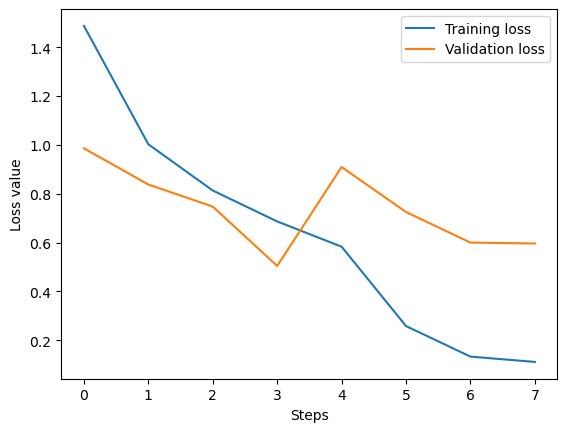

In [359]:
plt.plot(range(n_epochs), adv_train_loss_list)
plt.plot(range(n_epochs), adv_val_loss_list)
plt.legend(["Training loss", "Validation loss"])
plt.xlabel("Steps")
plt.ylabel("Loss value")
plt.show()

### Task 9 (10 pts)

Until now, we asked you to keep the seed fixed.  
Train **the model you defined at Task 5** five times with 5 different seeds (already specified below, **don't change them**), each for the same number of epochs epochs.  
Don't change other hyperparameters. Observe the accuracy of the test set in each case. What can you say?  

In [70]:
def trainForSeeds():
    for seed in range(5):
        torch.manual_seed(seed)
        print(f"Testing seed {seed}:\n", flush = True)
        def resetModel():
            global model, optimizer, train_loss_list, validation_loss_list
            train_loss_list = []
            validation_loss_list = []
            model = CNN()
            optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.9)
            model = model.to(DEVICE)
            return model, optimizer

        model, optimizer = resetModel()
        trainBaseModel()
        
        # Evaluate on test set
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for data, target in testloader:
                data, target = data.to(DEVICE), target.to(DEVICE)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += target.size(0)
                n_correct += (predicted == target).sum().item()
            
            acc = 100.0 * n_correct / n_samples
        print(f"Seed {seed} - Test Accuracy: {acc:.2f}%\n")

#TODO trainForSeeds()

## Questions

During the presentation, we may ask questions to ensure you have understood the core concepts of the course. Examples include:
1. Where are the parameters that a CNN learns during training?
2. Why do we use convolutional layers instead of fully connected layers for image data?
3. What is the role of pooling layers? What would happen if we removed them?
4. What is Dropout? Batch Normalizaton? Do you have other regularization tecniques in mind?